In [1]:
import sys
import os
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/mnist')
sys.path.append('C:/Users/dinle/Code/Learning/Py_Code/AI_Learning/NodeLayer')
from NodeLayer.Networks.multi_layer_net_extend import MultiLayerNetExtend as MLE1
from NodeLayer.Networks.simple_convnet import SimpleConvNet as CVS1
from NodeLayer.Networks.deep_convnet import DeepConvNet as CVD1
from mnist.common.multi_layer_net_extend import MultiLayerNetExtend as MLE2
from mnist.ch07.simple_convnet import SimpleConvNet as CVS2
from mnist.ch08.deep_convnet import DeepConvNet as CVD2
import matplotlib.pyplot as plt
from mnist.dataset.mnist import load_mnist
from mnist.common.util import smooth_curve
from mnist.common.optimizer import *
import numpy as np
import time


In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
x_train = x_train[:1000]
t_train = t_train[:1000]
train_size = x_train.shape[0]
test_size = x_test.shape[0]
batch_size = 100
max_iterations = 1000
print_iter = 100
mi = np.arange(max_iterations)
optimizer = AdaGrad()

In [3]:
def test(test_list, max_acc=None):
    networks = {}
    train_acc = {}
    train_loss = {}
    test_acc = {}
    test_loss = {}
    optimizer = {}
    total_step = {}
    time_record = {}

    for key in test_list.keys():
        # 기록 리스트 생성
        train_acc[key] = []
        train_loss[key] = []
        test_acc[key] = []
        test_loss[key] = []
        total_step[key] = 0
        time_record[key] = 0

        # nSigmoid 경우 파라미터
        # key == 'nSigmoid_8' -> act = nSigmoid, threshold = 8
        model = test_list[key]['model']
        opt = test_list[key]['opt']
        lr = test_list[key]['lr']


        # 네트워크 모델 생성
        if model == 'MLE1':
            act = test_list[key]['act']
            std = test_list[key]['std']
            dr = test_list[key]['dr']
            bn = test_list[key]['bn']
            bp = test_list[key]['bp']
            do = False
            if dr is not None:
                do = True
            networks[key] = MLE1(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                output_size=10, use_dropout=do, dropout_ration=dr, activation=act, weight_init_std=std, use_batchnorm=bn, batch_pos=bp)
        elif model == 'MLE2':
            act = test_list[key]['act']
            std = test_list[key]['std']
            dr = test_list[key]['dr']
            bn = test_list[key]['bn']
            do = False
            if dr is not None:
                do = True
            networks[key] = MLE2(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                 output_size=10, use_dropout=do, dropout_ration=dr, activation=act, weight_init_std=std, use_batchnorm=bn)
        elif model == 'CVS1':
            networks[key] = CVS1()
        elif model == 'CVS2':
            networks[key] = CVS2()
        elif model == 'CVD1':
            networks[key] = CVD1()
        elif model == 'CVD2':
            networks[key] = CVD2()
        else:
            assert 'no model' + model

        # optimizer 생성
        if opt == 'SGD':
            optimizer[key] = SGD(lr)
        elif opt == 'AdaGrad':
            optimizer[key] = AdaGrad(lr)
        elif opt == 'Adam':
            optimizer[key] = Adam(lr)
        else:
            assert 'no opt' + opt

    # 파라미터 통일
    networks1 = networks['My']
    networks2 = networks['Text']
    for k in networks1.params.keys():
        for i in range(networks1.params[k].shape[0]):
            networks1.params[k][i] = networks2.params[k][i].copy()

    # 학습
    for i in range(max_iterations):
        # if 0 not in total_step.values():
        #     print("All test list training Done\nStep: " + str(i))
        #     break

        # mini-batch train
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        # mini-batch test
        batch_mask_t = np.random.choice(test_size, batch_size)
        x_batch_t = x_test[batch_mask_t]
        t_batch_t = t_test[batch_mask_t]

        # print_iter 회마다 경과 출력
        if i % print_iter == 0:
            print( "="*15 + "iteration:" + str(i) + "="*15)
            print("{:^9}|{:^9}|{:^9}|{:^9}".format('model','time','acc','loss'))

        # 학습 & 추론 & 기록
        for key in test_list.keys():
            if total_step[key] != 0:
                # Max acc 에 도달해 학습이 끝난 test model
                continue
            else:
                start = time.time()
                # CV 모델 데이터 처리
                if test_list[key]['model'].startswith('CV'):
                    x_batch = x_batch.reshape(-1, 1, 28, 28)
                    x_batch_t = x_batch_t.reshape(-1, 1, 28, 28)
                #
                # # 학습(역전파)
                # b_strat = time.time()

                grads = networks[key].gradient(x_batch, t_batch)
                optimizer[key].update(networks[key].params, grads)
                # b_end = time.time()
                # print(key, "학습: ", b_end - b_strat)

                # 추론(순전파)
                if key.endswith("1"):
                    # f_strat = time.time()
                    tr_acc, tr_loss = networks[key].acc_and_loss(x_batch, t_batch)
                    ts_acc, ts_loss = networks[key].acc_and_loss(x_batch_t, t_batch_t)
                    f_end = time.time()
                    # print(key, "추론: ", f_end - f_strat)
                else:
                    # f_strat = time.time()
                    if test_list[key]['model'].startswith('CV'):
                        tr_acc = networks[key].accuracy(x_batch, t_batch, batch_size)
                        ts_acc = networks[key].accuracy(x_batch_t, t_batch_t, batch_size)
                    else:
                        tr_acc = networks[key].accuracy(x_batch, t_batch)
                        ts_acc = networks[key].accuracy(x_batch_t, t_batch_t)
                    tr_loss = networks[key].loss(x_batch, t_batch)
                    ts_loss = networks[key].loss(x_batch_t, t_batch_t)
                    # f_end = time.time()
                    # print(key, "추론: ", f_end - f_strat)

                # 기록
                train_acc[key].append(tr_acc)
                train_loss[key].append(tr_loss)
                test_acc[key].append(ts_acc)
                test_loss[key].append(ts_loss)
                end = time.time()
                time_record[key] += (end-start)

                # max accuracy 도달 해당 모델 학습 종료
                if max_acc and max_acc <= ts_acc:
                    total_step[key] = i
                    print(key + " training end!\nacc : " + str(ts_acc) + " step: " + str(i))

                # print_iter 회마다 경과 출력
                if i % print_iter == 0:
                    print("{:^9}| {:0<7.3f} | {:0<.5f} | {:0<.5f}".format(key, time_record[key],tr_acc,tr_loss))

    return train_acc, train_loss, test_acc, test_loss, total_step


def plot(label, datas, t_list, *y_lim):
    for key in t_list:
        plt.plot( smooth_curve(datas[key]), markevery=50, label=key)
    plt.xlabel("iterations")
    plt.ylabel(label)
    if y_lim:
        plt.ylim(y_lim)
    plt.legend()
    plt.show()

In [4]:
test_list = {
             'My':
                 {'model':'MLE1','opt':'SGD','act':'relu','std':'he','dr':None,'bn':False,'bp':1,'lr':0.01},
             'Text':
                 {'model':'MLE2','opt':'SGD','act':'relu','std':'he','dr':None,'bn':False,'bp':1,'lr':0.01},
             # '0.086_My':
             #     {'model':'MLE1','opt':'SGD','act':'relu','std':0.086,'dr':None,'bn':False,'bp':1,'lr':0.01},
             # '0.086_Text':
             #     {'model':'MLE2','opt':'SGD','act':'relu','std':0.086,'dr':None,'bn':False,'bp':1,'lr':0.01},
             # 'DpCV1':
             #     {'model':'CVD1','opt':'Adam','act':'relu','std':'he','dr':None,'bn':True,'bp':0,'lr':0.01},
             # 'DpCV2':
             #     {'model':'CVD2','opt':'Adam','act':'relu','std':'he','dr':None,'bn':True,'bp':0,'lr':0.01},
             # 'DpCV11':
             #     {'model':'CVD1','opt':'Adam','act':'relu','std':'he','dr':None,'bn':True,'bp':0,'lr':0.01},
             # 'DpCV22':
             #     {'model':'CVD2','opt':'Adam','act':'relu','std':'he','dr':None,'bn':True,'bp':0,'lr':0.01},
            # 'Node_BN2':
            #      {'model':'mt1','opt':'AdaGrad','act':'relu','std':'he','dr':None,'bn':True,'bp':2,'lr':0.01},
            #   'Text':
            #     {'model':'mt2','act':'relu','std':'he','dr':None,'bn':False,'lr':0.01},
            # 'Text_BN':
            #     {'model':'mt2','act':'relu','std':'he','dr':None,'bn':True,'lr':0.01},
             }



train_acc, train_loss, test_acc, test_loss, total_step = test(test_list, 0.99)

===============iteration:0===============
  model  |  time   |   acc   |  loss   
   My    | 0.01500 | 0.13000 | 2.33233
  Text   | 0.01300 | 0.13000 | 2.33233
===============iteration:100===============
  model  |  time   |   acc   |  loss   
   My    | 1.37400 | 0.70000 | 1.48208
  Text   | 1.22800 | 0.70000 | 1.48192
===============iteration:200===============
  model  |  time   |   acc   |  loss   
   My    | 2.68300 | 0.81000 | 0.65008
  Text   | 2.40600 | 0.81000 | 0.65066
===============iteration:300===============
  model  |  time   |   acc   |  loss   
   My    | 3.99400 | 0.83000 | 0.59629
  Text   | 3.47800 | 0.84000 | 0.59620
===============iteration:400===============
  model  |  time   |   acc   |  loss   
   My    | 5.35700 | 0.95000 | 0.24773
  Text   | 4.55300 | 0.95000 | 0.24738
===============iteration:500===============
  model  |  time   |   acc   |  loss   
   My    | 6.70700 | 0.95000 | 0.22465
  Text   | 5.62600 | 0.95000 | 0.22411
===============iteration:600==

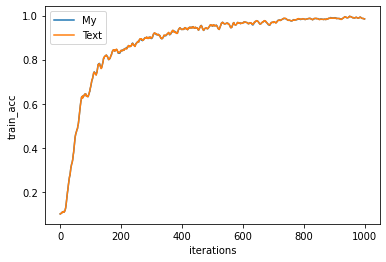

In [5]:
plot('train_acc', train_acc, test_list)

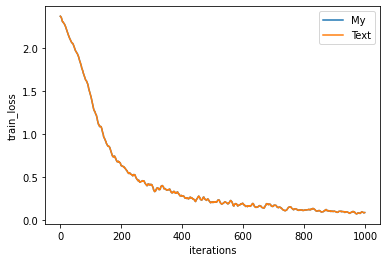

In [6]:
plot('train_loss', train_loss, test_list)

In [7]:
print(total_step)

{'My': 0, 'Text': 0}


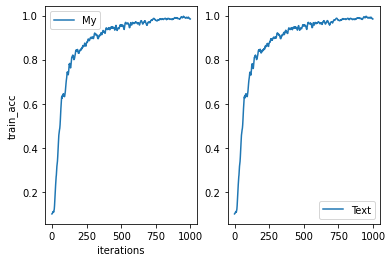

In [14]:
plt.subplot(1,2,1)

plt.plot( smooth_curve(train_acc['My']), markevery=50, label='My')
plt.xlabel("iterations")
plt.ylabel('train_acc')
plt.legend()

plt.subplot(1,2,2)
plt.plot( smooth_curve(train_acc['Text']), markevery=50, label='Text')
plt.legend()
plt.show()